In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


* Loading all the datasets.

In [2]:
train = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
sample = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv")
movies = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")
test = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")

* Getting a brief view of the datasets.

In [3]:
movies.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [4]:
train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


* Loading all the libraries.

In [5]:
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2
from mpl_toolkits import mplot3d
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectPercentile, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.decomposition import TruncatedSVD

* Checking the shape and types of features of the datasets.

In [6]:
print(movies.shape)
print(train.shape)
print(test.shape)

(143258, 14)
(162758, 5)
(55315, 4)


In [7]:
print(movies.dtypes)
print(train.dtypes)
print(test.dtypes)

movieid                  object
title                    object
audienceScore           float64
rating                   object
ratingContents           object
releaseDateTheaters      object
releaseDateStreaming     object
runtimeMinutes          float64
genre                    object
originalLanguage         object
director                 object
boxOffice                object
distributor              object
soundType                object
dtype: object
movieid               object
reviewerName          object
isFrequentReviewer      bool
reviewText            object
sentiment             object
dtype: object
movieid         object
reviewerName    object
isTopCritic       bool
reviewText      object
dtype: object


* Getting movies and train data information.

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


* Checking null values.

In [10]:
train.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

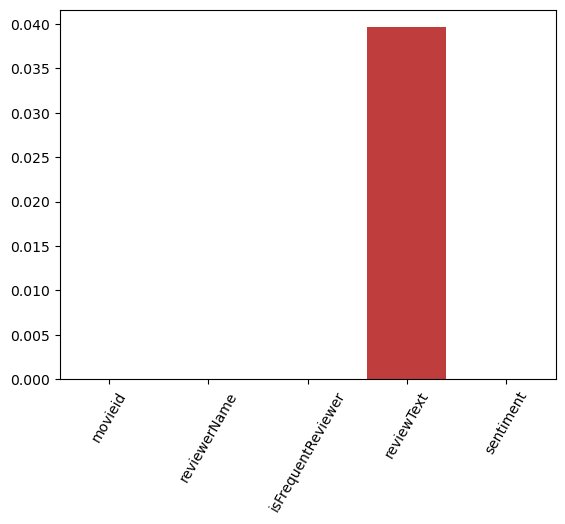

In [11]:
null_train = train.isnull().sum()/len(train)
sns.barplot(x=null_train.index, y=null_train.values)
plt.xticks(rotation=60)
plt.show()

In [12]:
movies.isnull().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

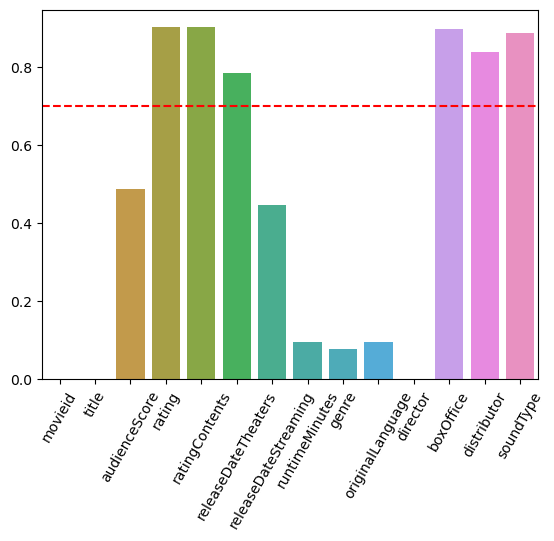

In [13]:
null_movies = movies.isnull().sum()/len(movies)
sns.barplot(x=null_movies.index, y=null_movies.values)
plt.axhline(y = 0.7, color = 'r', linestyle = 'dashed')
plt.xticks(rotation=60)
plt.show()

* By taking the null values into account, we remove all the features which have more than 70% null values. Using such features might improve the score but can also lead to bias and poor generalisation.

* Visualising the distribution of sentiment classes.

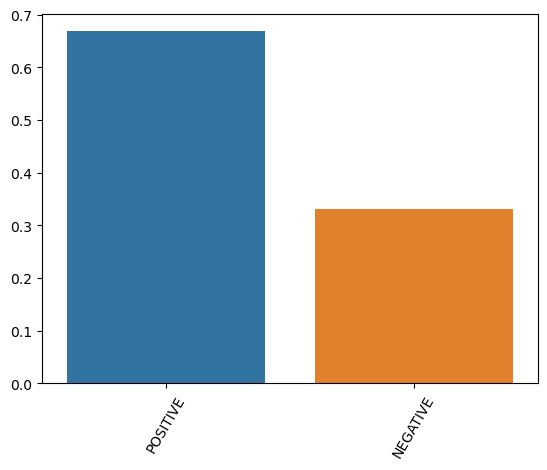

In [14]:
sentiment_graph = train.loc[:,'sentiment']
sns.barplot(x=sentiment_graph.value_counts().index, y=sentiment_graph.value_counts().values/len(sentiment_graph))
plt.xticks(rotation=60)
plt.show()

* Now we check all the features and their statistics to validate our choice of columns. 

In [15]:
train.describe(include='all').T

,count,unique,top,freq
movieid,162758,16812,escape_the_terminator_tyler_durden_astonish,708
reviewerName,162758,4482,Sherri Morrison,962
isFrequentReviewer,162758,2,False,113189
reviewText,156311,155071,Parental Content Review,29
sentiment,162758,2,POSITIVE,108761


In [16]:
movies.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
movieid,143258,126404,escape_the_terminator_tyler_durden_astonish,367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,143258,126404,Escape The Terminator Tyler Durden Astonish,367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
audienceScore,73248.0,NaN,NaN,NaN,55.674967,24.553648,0.0,37.0,57.0,76.0,100.0
rating,13991,10,R,7734,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratingContents,13991,8353,['Language'],365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
releaseDateTheaters,30773,12062,2018-09-14,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
releaseDateStreaming,79420,4726,2017-05-22,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
runtimeMinutes,129431.0,NaN,NaN,NaN,93.708578,28.129175,1.0,84.0,92.0,103.0,2700.0
genre,132175,2912,Drama,27860,NaN,NaN,NaN,NaN,NaN,NaN,NaN
originalLanguage,129400,112,English,85034,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* We select movieid, audienceScore, boxOffice (even though it has too many null values using it makes sense), runtimeMinutes, genre, originalLanguage and director in our movies dataset for now. Genre has been split into different columns and then only one genre is taken as the second genre is not available for majority of rows.

In [17]:
new_movies = movies.loc[:,['movieid', 'audienceScore', 'boxOffice', 'runtimeMinutes', 'originalLanguage', 'genre', 'director']]
new_movies['genre'] = new_movies.genre.str.split(',', expand=True).loc[:,0]
new_movies

,movieid,audienceScore,boxOffice,runtimeMinutes,originalLanguage,genre,director
0,han_solo_heroic_myth_wonder_woman,50.0,NaN,75.0,English,Comedy,Claude Nicolet
1,voyage_tyler_durden_han_solo_stardust,NaN,NaN,114.0,English,Drama,Nathan Haack
2,norman_bates_ferris_bueller_hermione_granger_v...,43.0,NaN,120.0,Korean,Drama,Theresa Smith
3,elegant_hermione_granger,60.0,NaN,90.0,English,Action,Donald Lewis
4,adventure_rocky_balboa,70.0,NaN,80.0,English,Fantasy,Howard Simms
...,...,...,...,...,...,...,...
143253,sherlock_holmes_surreal_james_bond,14.0,NaN,90.0,Japanese,Action,William Sims
143254,mr._miyagi_katniss_everdeen_harmony,NaN,NaN,99.0,English,Drama,Robert Paddock
143255,elegant_emerald_valiant_donnie_darko,71.0,NaN,43.0,English,Documentary,Roy Lovelace
143256,wonder_hermione_granger_hulk_v,NaN,NaN,63.0,English,Drama,Dwayne Clayton


* This dataset has a lot of duplicate rows with the same movieid. These are dealt with by keeping the first row of the group of the same movieid.

In [18]:
new_movies.drop_duplicates(subset=['movieid'], keep='first', inplace=True)

In [19]:
new_movies.isnull().sum()

movieid                  0
audienceScore        62690
boxOffice           113876
runtimeMinutes       12494
originalLanguage     12384
genre                10003
director                 0
dtype: int64

In [20]:
train.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

* We convert the boxOffice feature into numerical values for analysis.

In [21]:
def handle_box_office(value):
    if type(value)==float:
        return value
    else:
        value = value[1:]
        if value[-1]=='M':
            value= float(value[:-1])*1000000
        elif value[-1]=='K':
            value= float(value[:-1])*1000
        else:
            value= float(value)
        return value

In [22]:
new_movies['boxOffice'] = new_movies.apply(lambda row: handle_box_office(row['boxOffice']), axis=1)

In [23]:
new_movies

,movieid,audienceScore,boxOffice,runtimeMinutes,originalLanguage,genre,director
0,han_solo_heroic_myth_wonder_woman,50.0,NaN,75.0,English,Comedy,Claude Nicolet
1,voyage_tyler_durden_han_solo_stardust,NaN,NaN,114.0,English,Drama,Nathan Haack
2,norman_bates_ferris_bueller_hermione_granger_v...,43.0,NaN,120.0,Korean,Drama,Theresa Smith
3,elegant_hermione_granger,60.0,NaN,90.0,English,Action,Donald Lewis
4,adventure_rocky_balboa,70.0,NaN,80.0,English,Fantasy,Howard Simms
...,...,...,...,...,...,...,...
143252,james_bond_jason_bourne,NaN,NaN,131.0,Hindi,Action,Reginald Davis
143253,sherlock_holmes_surreal_james_bond,14.0,NaN,90.0,Japanese,Action,William Sims
143254,mr._miyagi_katniss_everdeen_harmony,NaN,NaN,99.0,English,Drama,Robert Paddock
143255,elegant_emerald_valiant_donnie_darko,71.0,NaN,43.0,English,Documentary,Roy Lovelace


* Now we merge the training and the new movies dataset.

In [24]:
merged_train = pd.merge(train, new_movies, on='movieid', how='left')
merged_train

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,audienceScore,boxOffice,runtimeMinutes,originalLanguage,genre,director
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,65.0,NaN,105.0,English,Comedy,Bennie Basso
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,NaN,NaN,91.0,English,Action,Alma White
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,80.0,115700000.0,130.0,English,Drama,Bobby Oleary
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,NaN,NaN,15.0,Spanish,Drama,Eric Hutcherson
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE,97.0,7600000.0,131.0,Portuguese (Brazil),Crime,John Trent
...,...,...,...,...,...,...,...,...,...,...,...
162753,the_joker_ethereal_captain_jack_sparrow_fantastic,Danny Mueller,False,A top-notch thriller with genuine surprises an...,POSITIVE,NaN,NaN,96.0,English,Romance,Gertrude Fonner
162754,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...,NEGATIVE,20.0,28800000.0,102.0,English,Comedy,Susan Oley
162755,infinite_enigma_luke_skywalker,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them...",POSITIVE,78.0,NaN,90.0,English,Comedy,Bryant Reams
162756,emerald_oracle_iron_man_wolverine,Erik Parker,False,"The film is rescued by a strong third act, but...",NEGATIVE,39.0,60600000.0,88.0,English,Kids & family,Lisa Cruz


* We check the correlation of the numerical features with the target feature

<Axes: >

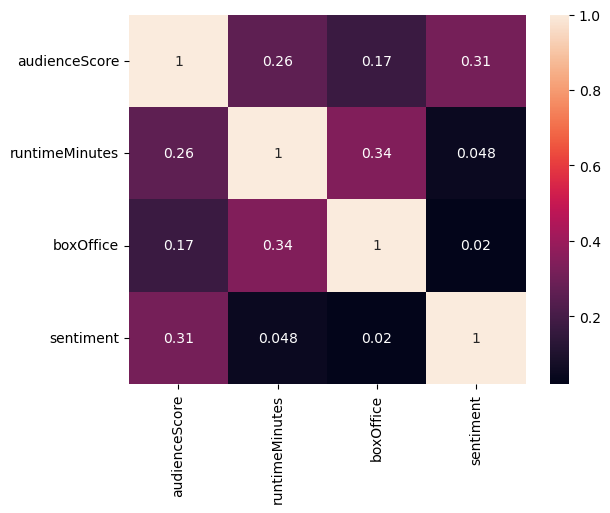

In [25]:
letemp = LabelEncoder()
label_sentiment = letemp.fit_transform(merged_train.loc[:,'sentiment'])
num_feat_cor = merged_train.loc[:,['audienceScore', 'runtimeMinutes', 'boxOffice']]
num_cor = pd.DataFrame(np.hstack((num_feat_cor, label_sentiment.reshape(-1,1))), columns = ['audienceScore','runtimeMinutes', 'boxOffice', 'sentiment'])
sns.heatmap(num_cor.corr(), annot=True)

* **Only audienceScore is related to target feature according to above correlation matrix.**

* We also make boxplots of numerical data.

<Axes: ylabel='audienceScore'>

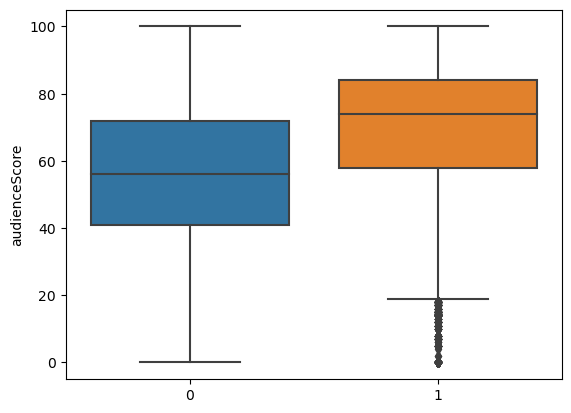

In [26]:
sns.boxplot(y=merged_train.loc[:,'audienceScore'], x=label_sentiment)

<Axes: ylabel='boxOffice'>

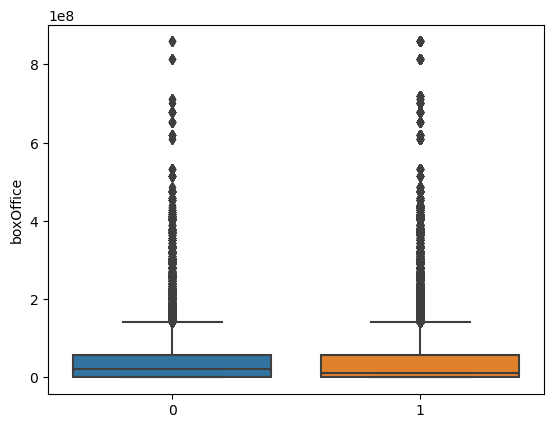

In [27]:
sns.boxplot(y=merged_train.loc[:,'boxOffice'], x=label_sentiment)

<Axes: ylabel='runtimeMinutes'>

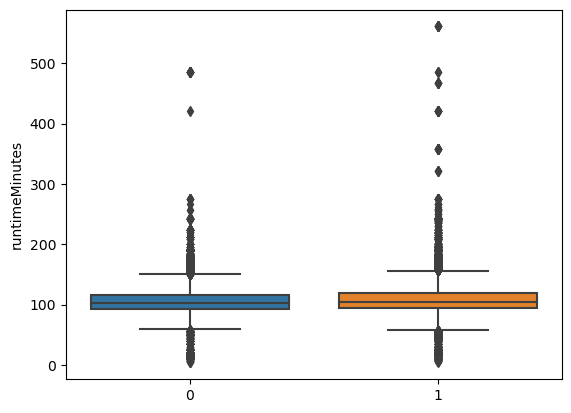

In [28]:
sns.boxplot(y=merged_train.loc[:,'runtimeMinutes'], x=label_sentiment)

* We check the chi2 values for the categorical features to determine which features to choose.
* For this we first create the cross tabulation of the numeric features.

In [29]:
ct_movie_id = pd.crosstab(merged_train.loc[:300,'movieid'],merged_train.loc[:300,'sentiment'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_movie_id)
print(chi2_stat, p, dof)

296.59761904761905 0.47928619869613326 296


* critical value (337.1254) > chi sq (296.5976) and p value>0.05.
* So movieid and sentiment are unrelated.

In [30]:
ct_genre = pd.crosstab(merged_train.loc[:300,'genre'],merged_train.loc[:300,'sentiment'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_genre)
print(chi2_stat, p, dof)

30.422594215266997 0.023453578201779963 17


* critical value (27.5871) < chi sq (30.4225) and p value<0.05.
* So genre and sentiment are related.

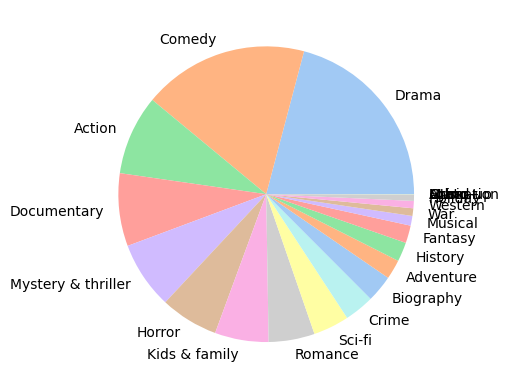

In [31]:
colours = sns.color_palette('pastel')[0:23]
plt.pie(merged_train.loc[:,'genre'].value_counts().values, labels = merged_train.loc[:,'genre'].value_counts().index, colors=colours)
plt.show()

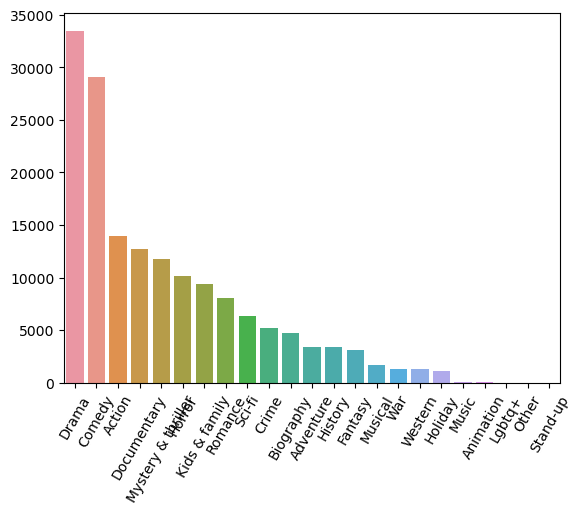

In [32]:
sns.barplot(x=merged_train.loc[:,'genre'].value_counts().index, y=merged_train.loc[:,'genre'].value_counts().values)
plt.xticks(rotation=60)
plt.show()

* **Distribution of genre feature.**

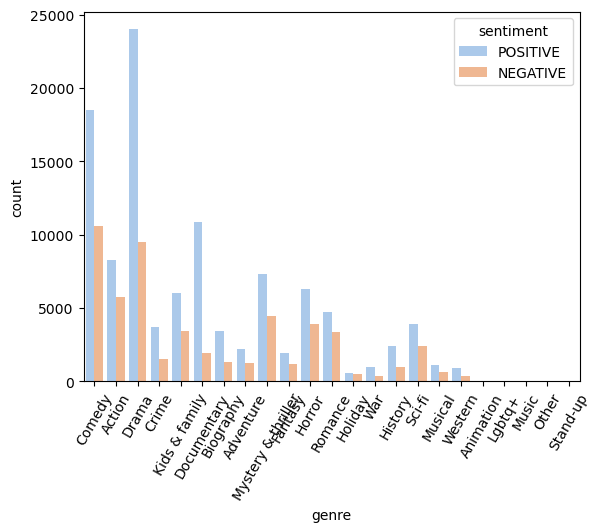

In [33]:
sns.countplot(data=merged_train, x='genre', hue='sentiment', palette='pastel')
plt.xticks(rotation=60)
plt.show()

* **Distribution of genre feature with sentiment analysis.**

In [34]:
ct_dir = pd.crosstab(merged_train.loc[:300,'director'],merged_train.loc[:300,'sentiment'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_dir)
print(chi2_stat, p, dof)

277.52063492063496 0.47988976796387944 277


* critical value (316.8185) > chi sq (277.5206) and p value>0.05.
* So director and sentiment are unrelated.

<Axes: xlabel='sentiment', ylabel='director'>

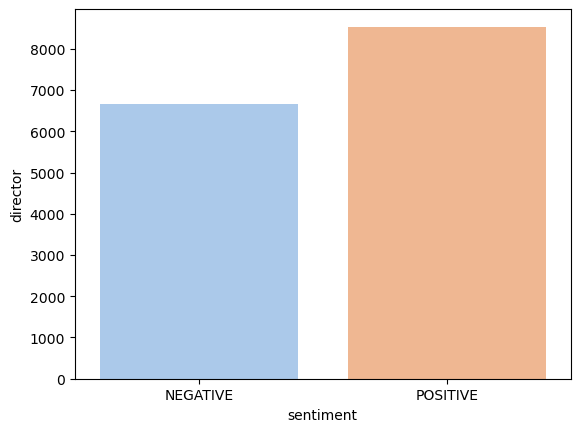

In [35]:
dir_sentiment_counts = merged_train.groupby('sentiment')['director'].nunique().reset_index()
sns.barplot(data=dir_sentiment_counts, x='sentiment', y='director', palette='pastel')

* **Number of directors with sentiment distribution.**

In [36]:
ct_rev_name = pd.crosstab(merged_train.loc[:300,'reviewerName'],merged_train.loc[:300,'sentiment'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_rev_name)
print(chi2_stat, p, dof)

268.71587301587306 0.47620211010186125 268


* critical value (307.1838) > chi sq (268.7158) and p value>0.05.
* So reviewerName and sentiment are unrelated.

<Axes: xlabel='sentiment', ylabel='reviewerName'>

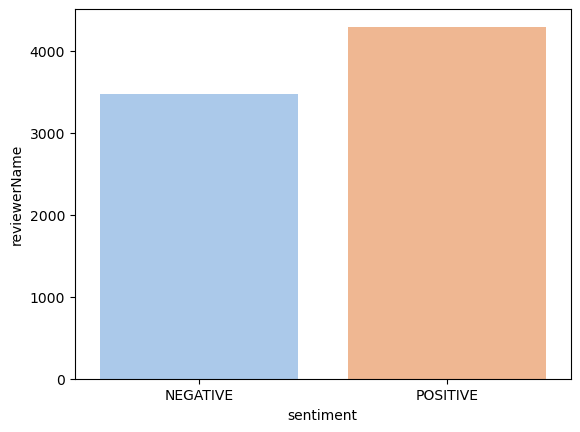

In [37]:
rev_sentiment_counts = merged_train.groupby('sentiment')['reviewerName'].nunique().reset_index()
sns.barplot(data=rev_sentiment_counts, x='sentiment', y='reviewerName', palette='pastel')

* **Number of Reviewers with sentiment distribution.**

In [38]:
ct_freq_rev = pd.crosstab(merged_train.loc[:300,'isFrequentReviewer'],merged_train.loc[:300,'sentiment'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_freq_rev)
print(chi2_stat, p, dof)

3.3102953506097537 0.06884711737864052 1


* critical value (3.8415) > chi sq (3.3102) and p value>0.05.
* So isFrequentReviewer and sentiment are unrelated.

In [39]:
ct_ol = pd.crosstab(merged_train.loc[:300,'originalLanguage'],merged_train.loc[:300,'sentiment'])
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_ol)
print(chi2_stat, p, dof)

30.683252681964504 0.07909345483557624 21


* critical value (32.6706) > chi sq (30.6832)  and p value>0.05.
* So originalLanguage and sentiment are unrelated.

In [40]:
merged_train.loc[:,['originalLanguage', 'sentiment']].groupby('originalLanguage').value_counts()

originalLanguage  sentiment
Afrikaans         POSITIVE     34
                  NEGATIVE     13
Albanian          POSITIVE     34
                  NEGATIVE      3
Amharic           POSITIVE      8
                               ..
Xhosa             POSITIVE      4
Yiddish           POSITIVE     19
                  NEGATIVE     16
crp               POSITIVE      8
                  NEGATIVE      3
Length: 166, dtype: int64

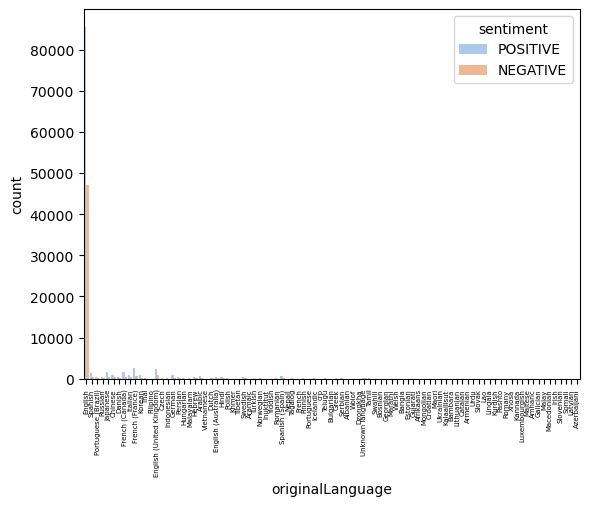

In [41]:
sns.countplot(data=merged_train, x='originalLanguage', hue='sentiment', palette='pastel')
#plt.set_xlabel('originalLanguage', fontsize=0.1)
plt.xticks(rotation=90, fontsize=5)
plt.show()

* **Distribution of originalLanguage feature with sentiment analysis.**

* Will remove empty reviewText as only 4% data is lost on train data. Doing this because replacing the na review text with empty string will imply that they gave some review for that movie when they did not.

In [42]:
merged_train = merged_train.dropna(subset=['reviewText'])
merged_train.isnull().sum()

movieid                   0
reviewerName              0
isFrequentReviewer        0
reviewText                0
sentiment                 0
audienceScore         12757
boxOffice             50353
runtimeMinutes         3252
originalLanguage       3143
genre                  2346
director                  0
dtype: int64

* Creating a function to clean the reviewText feature.

In [43]:
import re
def clean_text(text):
    if type(text)==float:
        return text
    else:
        text = text.lower()
        #text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
        text = re.sub(' +', ' ', text)
        return text
st = "ADRIFT ended    up just????@   @    ??   Selick’s        2009's    feeling small.???"
print(clean_text(st))

adrift ended up just????@ @ ?? selick’s 2009's feeling small.???


* The features runtimeMinutes and boxOffice are removed from above analysis. However, because of small difference between critical value and chi2 value of other features and  taking samples, we cannot be absolutely sure that those features are related or not. Moreover, on checking with these features, the models performed better with these features than without.

In [44]:
X_train = merged_train.loc[:, ['audienceScore', 'movieid', 'genre', 'director', 'originalLanguage', 'reviewerName', 'isFrequentReviewer', 'reviewText']]
X_train

,audienceScore,movieid,genre,director,originalLanguage,reviewerName,isFrequentReviewer,reviewText
0,65.0,marvelous_pirate,Comedy,Bennie Basso,English,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...
1,NaN,tony_montana_frodo_baggins_v_rocky_balboa,Action,Alma White,English,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...
2,80.0,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Drama,Bobby Oleary,English,Mr. Charles Burgess,True,Creed II does not give us anything but another...
3,NaN,lara_croft_glimmer,Drama,Eric Hutcherson,Spanish,Ryan Barrett,False,"I know what you're thinking, but this is no Li..."
4,97.0,jason_bourne_surreal_the_terminator_indiana_jones,Crime,John Trent,Portuguese (Brazil),Alexander Glover,False,Director Fernando Meirelles tells the story wi...
...,...,...,...,...,...,...,...,...
162753,NaN,the_joker_ethereal_captain_jack_sparrow_fantastic,Romance,Gertrude Fonner,English,Danny Mueller,False,A top-notch thriller with genuine surprises an...
162754,20.0,e.t._hannibal_lecter_vito_corleone_katniss_eve...,Comedy,Susan Oley,English,Jennifer Clayton,True,Some people find Derek Zoolander funny and lik...
162755,78.0,infinite_enigma_luke_skywalker,Comedy,Bryant Reams,English,Bryan Wilson,False,"This fun, gentle comedy focuses mainly on them..."
162756,39.0,emerald_oracle_iron_man_wolverine,Kids & family,Lisa Cruz,English,Erik Parker,False,"The film is rescued by a strong third act, but..."


* Applying the function to clean reviewText on train data.

In [45]:
X_train['reviewText'] = X_train.apply(lambda row: clean_text(row['reviewText']), axis=1)

* Using labelEncoder to encode sentiment to 0 and 1 as it can help some binary classifiers like linearSVC.

In [46]:
le = LabelEncoder()
y_train = merged_train.loc[:, 'sentiment']
y_trainf = le.fit_transform(y_train)

* Converting the stop words into a list for use in tfidf vectoriser.
* Did not use it as it decreased the accuracy.

In [47]:
"""text = '''a
about
after
all
also
an
and
any
are
as
at
be
because
been
but
by
can
co
corp
could
for
from
had
has
have
he
her
his
if
in
inc
into
is
it
its
last
more
most
mr
mrs
ms
mz
no
not
of
on
one
only
or
other
out
over
s
says
she
so
some
such
than
that
the
their
there
they
this
to
up
was
we
were
when
which
who
will
with
would
'''
text_list = ' '.join(text.splitlines())
text_list = text_list.strip().split(' ')
text_list"""

"text = '''a\nabout\nafter\nall\nalso\nan\nand\nany\nare\nas\nat\nbe\nbecause\nbeen\nbut\nby\ncan\nco\ncorp\ncould\nfor\nfrom\nhad\nhas\nhave\nhe\nher\nhis\nif\nin\ninc\ninto\nis\nit\nits\nlast\nmore\nmost\nmr\nmrs\nms\nmz\nno\nnot\nof\non\none\nonly\nor\nother\nout\nover\ns\nsays\nshe\nso\nsome\nsuch\nthan\nthat\nthe\ntheir\nthere\nthey\nthis\nto\nup\nwas\nwe\nwere\nwhen\nwhich\nwho\nwill\nwith\nwould\n'''\ntext_list = ' '.join(text.splitlines())\ntext_list = text_list.strip().split(' ')\ntext_list"

* Now we perform preprocessing on the whole dataset.
* First we select all the columns according to their categories. Then we process them accordingly. Imputing and encoding is done on categorical, imputing and scaling on numerical and tfid vectoriser on text feature.
* Tried using maxabsScaler with CountVectoriser, did not improve accuracy.

In [48]:
num_feat = ['audienceScore']
cat_feat = ['movieid', 'genre', 'director', 'originalLanguage', 'reviewerName', 'isFrequentReviewer']
#cat_count_feat = ['reviewerName', 'director']
text_feat = ['reviewText']
num_pipe = Pipeline(steps=[('mean_imp', SimpleImputer(missing_values=np.nan, strategy='mean')), ('minmax_sc', MinMaxScaler())])
cat_pipe = Pipeline(steps=[('freq_imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), ('oh_enc', OneHotEncoder(handle_unknown='infrequent_if_exist'))])
#text_clf = Pipeline(steps=[('count_vect' ,CountVectorizer()),('tfid', TfidfTransformer())])
#count_vec= CountVectorizer(ngram_range=(2,2))
#count_vec_pipe = Pipeline(steps= [('count_vec', CountVectorizer(ngram_range=(2,2))), ('maxabs_sc', MaxAbsScaler())])
#('cat_count_reviewer' ,count_vec, 'reviewerName'), ('cat_count_director' ,count_vec, 'director')
tfidf=TfidfVectorizer(ngram_range=(1,4))
ct = ColumnTransformer([('cat',cat_pipe, cat_feat), ('num',num_pipe, num_feat), ("review_text", tfidf, 'reviewText')])

In [49]:
X_train_ct = ct.fit_transform(X_train)
X_train_ct

<156311x5963743 sparse matrix of type '<class 'numpy.float64'>'
	with 13269000 stored elements in Compressed Sparse Row format>

* Using SelectFromModel to select features based on feature importances given by a trained model. Best threshold came out to be 0.3*mean by hit and trial.
* Then used selectPercentile metric, selected percentile according to performance. Gave almost same results.

In [50]:
#logreg_fs = LogisticRegression()
#lsvc_fs= LinearSVC()
#sgd_mod_fs = SGDClassifier(loss='modified_huber', max_iter=100)
#sfm = SelectFromModel(lsvc_fs, threshold='0.3*mean').fit(X_train_ct, y_trainf)
sp = SelectPercentile(chi2, percentile=60).fit(X_train_ct, y_trainf)
X_trainf = sp.transform(X_train_ct)
X_trainf.shape

(156311, 3578245)

* I used TruncatedSVD to try to visualise data in smaller dimensions.

In [51]:
pca_3D = TruncatedSVD(n_components = 3)
X_3D = pca_3D.fit_transform(X_trainf)

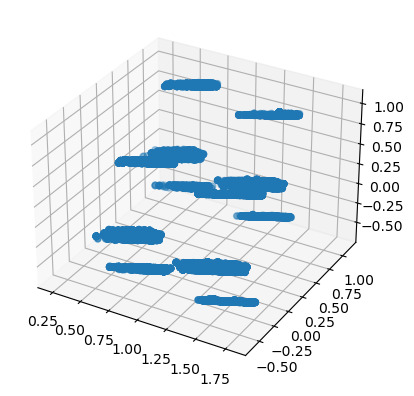

In [52]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_3D[:,0], X_3D[:,1], X_3D[:,2])

In [53]:
pca_2D = TruncatedSVD(n_components = 2)
X_2D = pca_2D.fit_transform(X_trainf)

<Axes: >

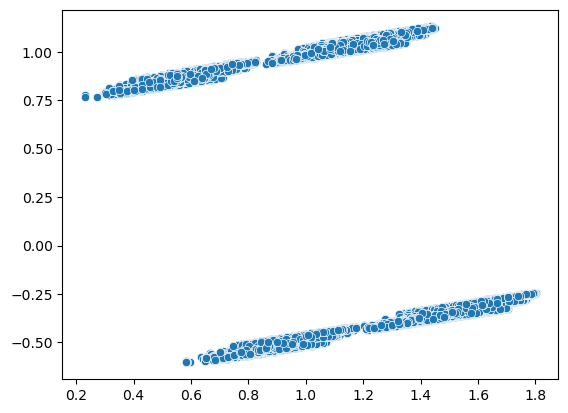

In [54]:
sns.scatterplot(x=X_2D[:,0], y=X_2D[:,1])

In [55]:
'''X_trn, X_tst, y_trn, y_tst = train_test_split(X_2D, y_trainf, test_size=0.3, random_state=123)
lr = LogisticRegression().fit(X_trn, y_trn)
y_pred = lr.predict(X_tst)
print(classification_report(y_tst, y_pred))'''
#0.67 f1 score

'X_trn, X_tst, y_trn, y_tst = train_test_split(X_2D, y_trainf, test_size=0.3, random_state=123)\nlr = LogisticRegression().fit(X_trn, y_trn)\ny_pred = lr.predict(X_tst)\nprint(classification_report(y_tst, y_pred))'

* Tried using kernel approximation for dimensionality reduction thinking it might help models like linear SVC but it did not improve the accuracy of the models, made it worse.

In [56]:
'''feature_map_nystroem = Nystroem(n_components=100)
X_trainff = feature_map_nystroem.fit_transform(X_trainf)
X_trainff.shape'''

'feature_map_nystroem = Nystroem(n_components=100)\nX_trainff = feature_map_nystroem.fit_transform(X_trainf)\nX_trainff.shape'

In [57]:
'''rbf_feature = RBFSampler(n_components=1000)
X_trainff = rbf_feature.fit_transform(X_trainf)
X_trainff.shape'''

'rbf_feature = RBFSampler(n_components=1000)\nX_trainff = rbf_feature.fit_transform(X_trainf)\nX_trainff.shape'

* Ultimately we decided against using dimensionality reduction as the less likely case of filtering of noise and unneccesary data leadinng to a good result did not happen. Moreover, one of the major objectives of dimensionality reduction is to reduce training time which in return also loses some information. As almost all of the models only took 5-10 minutes in training on even millions of features, there was no need for dimensionality reduction.

* Splitting the training data to show classification reports, etc.

In [58]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X_trainf, y_trainf, test_size=0.3, random_state=123)

* Now we merge the testing and the new movies dataset.

In [59]:
merged_test = pd.merge(test, new_movies, on='movieid', how='left')
merged_test

,movieid,reviewerName,isTopCritic,reviewText,audienceScore,boxOffice,runtimeMinutes,originalLanguage,genre,director
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...,57.0,64000000.0,111.0,English,Holiday,Sara Barnett
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...,86.0,6200000.0,94.0,English,Drama,Cindy Flander
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...,62.0,NaN,NaN,French,Drama,Charlotte Bramble
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...,84.0,3100000.0,92.0,English,Drama,Jean Gainer
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...,NaN,NaN,66.0,Arabic,Drama,Marvin Short
...,...,...,...,...,...,...,...,...,...,...
55310,celestial_radiant,Jose Mccormick,False,Ron Howard delivers an unconventional romantic...,29.0,48400000.0,111.0,English,Comedy,Jill Fraser
55311,vivid_james_t._kirk,Thomas Osborne,False,As an oddball art film that openly invites you...,71.0,641100.0,116.0,English,Comedy,Daryl Wilson
55312,scarlett_o'hara_neo_scarlett_o'hara_infinite,Julie Kirby,False,Nicholson wears his devilish grin from his fir...,60.0,133800000.0,106.0,English,Comedy,Maria Tejada
55313,terminator_epic_rocky_balboa_mystic,Tina Sutton,True,It's hard not be entertained by two dozen of C...,65.0,13300000.0,125.0,English,Musical,Jermaine Fantasia


* Renamed the isFrequentReviewer to isTopCritic.

In [60]:
merged_test.rename(columns = {'isTopCritic':'isFrequentReviewer'}, inplace = True)

* Selecting all the features in test data which are available in train data.

In [61]:
X_test = merged_test.loc[:, ['audienceScore', 'movieid', 'genre', 'director', 'originalLanguage', 'reviewerName', 'isFrequentReviewer', 'reviewText']]
X_test

,audienceScore,movieid,genre,director,originalLanguage,reviewerName,isFrequentReviewer,reviewText
0,57.0,legend_marty_mcfly_oracle,Holiday,Sara Barnett,English,John Kim,False,Green slowly cranks up the dread with style an...
1,86.0,terminator_katniss_everdeen_glimmer,Drama,Cindy Flander,English,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,62.0,james_bond_labyrinth_gollum,Drama,Charlotte Bramble,French,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,84.0,v_quest_han_solo_wondrous,Drama,Jean Gainer,English,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,NaN,enigma_hulk_surreal_starlight,Drama,Marvin Short,Arabic,Justin Willis,False,An imaginative no-budget musical of sorts abou...
...,...,...,...,...,...,...,...,...
55310,29.0,celestial_radiant,Comedy,Jill Fraser,English,Jose Mccormick,False,Ron Howard delivers an unconventional romantic...
55311,71.0,vivid_james_t._kirk,Comedy,Daryl Wilson,English,Thomas Osborne,False,As an oddball art film that openly invites you...
55312,60.0,scarlett_o'hara_neo_scarlett_o'hara_infinite,Comedy,Maria Tejada,English,Julie Kirby,False,Nicholson wears his devilish grin from his fir...
55313,65.0,terminator_epic_rocky_balboa_mystic,Musical,Jermaine Fantasia,English,Tina Sutton,True,It's hard not be entertained by two dozen of C...


* Applying the function to clean reviewText on test data.

In [62]:
X_test['reviewText'] = X_test.apply(lambda row: clean_text(row['reviewText']), axis=1)

* Filling all null values in reviewText with empty strings because can't remove rows from test data.

In [63]:
X_test[['reviewText']] = X_test[['reviewText']].fillna("")
X_test.isnull().sum()

audienceScore         4931
movieid                  0
genre                  920
director                 0
originalLanguage      1238
reviewerName             0
isFrequentReviewer       0
reviewText               0
dtype: int64

* Performing transformations on the test set.

In [64]:
X_test_ct = ct.transform(X_test)
X_test_ct

<55315x5963743 sparse matrix of type '<class 'numpy.float64'>'
	with 2710163 stored elements in Compressed Sparse Row format>

In [65]:
X_testf = sp.transform(X_test_ct)
X_testf.shape

(55315, 3578245)

In [66]:
'''X_testff = rbf_feature.fit_transform(X_testf)
X_testff.shape'''

'X_testff = rbf_feature.fit_transform(X_testf)\nX_testff.shape'

In [67]:
#ct.transformers_[2][1].vocabulary_

* Finally we train the data on different models and check their performance through different methods.

In [68]:
#mnb = MultinomialNB()
#cross_val_score(mnb, X_trainf, y_trainf, cv=5)
'''0.71 f1 score'''

'0.71 f1 score'

In [69]:
#knc = KNeighborsClassifier()
#cross_val_score(knc, X_trainf, y_trainf, cv=5)
'''0.76 f1 score'''

'0.76 f1 score'

In [70]:
#param_grid = {'criterion':['entropy','gini'], 'splitter': ['random','best'], 'min_samples_leaf':[2,4,6,8,10], 'max_depth': [3, 5, 10, 50]}
#dtc= DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_leaf=2, max_depth=5, random_state=1)
#cross_val_score(dtc, X_trainf, y_trainf, cv=5, scoring='f1_macro')
'''0.69 f1 score'''

'0.69 f1 score'

In [71]:
#abc = AdaBoostClassifier()
#cross_val_score(abc, X_trainf, y_trainf, cv=5)
'''0.72 f1 score'''

'0.72 f1 score'

In [72]:
#bc = BaggingClassifier(estimator= LinearSVC(C=0.5, dual=True))
#cross_val_score(bc, X_trainf, y_trainf, cv=5, scoring='f1_micro')
'''0.84 f1 score'''

'0.84 f1 score'

In [73]:
#gbc = GradientBoostingClassifier()
#cross_val_score(gbc, X_trainf, y_trainf, cv=5, scoring='f1_micro')
'''0.72 f1 score'''

'0.72 f1 score'

In [74]:
#xgbc = XGBClassifier()
#cross_val_score(xgbc, X_trainf, y_trainf, cv=5, scoring='f1_micro')
'''0.79 f1 score'''

'0.79 f1 score'

* MLPClassifier takes a lot of time to fit. Hence, we use partial fit which reduces training time significantly. Moreover, partial fit gave much better accuracy than fit.
* Could not find fit model equivalent to partial fit so couldn't make its roc auc curve.
* As partial fit cannot be used with gscv, we have to check which parameters are best using hit and trial manually.

In [75]:
mlp = MLPClassifier(hidden_layer_sizes=(5, 5), alpha=0.0001, activation='identity', solver='adam')
# 0.846 f1 score
for i in range(0, X_trainf.shape[0], 67):
    if i==0:
        X_batch = X_trainf[i:i+67]
        y_batch = y_trainf[i:i+67]
        mlp.partial_fit(X_batch,y_batch, classes=np.unique(y_trainf))
    else:
        X_batch = X_trainf[i:i+67]
        y_batch = y_trainf[i:i+67]
        mlp.partial_fit(X_batch,y_batch)

* **MLPClassifer is our best model.**

In [76]:
mlp_cv = MLPClassifier(hidden_layer_sizes=(5, 5), alpha=0.0001, activation='identity', solver='adam')
for i in range(0, X_trn.shape[0], 67):
    if i==0:
        X_batch = X_trn[i:i+67]
        y_batch = y_trn[i:i+67]
        mlp_cv.partial_fit(X_batch,y_batch, classes=np.unique(y_trn))
    else:
        X_batch = X_trn[i:i+67]
        y_batch = y_trn[i:i+67]
        mlp_cv.partial_fit(X_batch,y_batch)
y_pred_mlp = mlp_cv.predict(X_tst)
print(classification_report(y_tst, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76     15444
           1       0.87      0.92      0.89     31450

    accuracy                           0.85     46894
   macro avg       0.84      0.82      0.83     46894
weighted avg       0.85      0.85      0.85     46894



<Axes: >

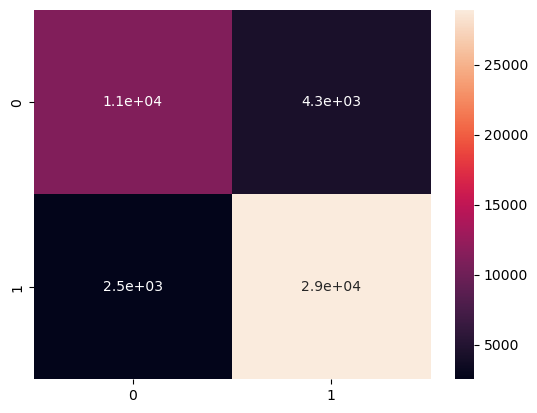

In [77]:
cm = confusion_matrix(y_tst, y_pred_mlp)
sns.heatmap(cm, annot=True)

In [78]:
'''mlp = MLPClassifier(hidden_layer_sizes=(5, 5), alpha=0.0001, activation='identity', solver='adam', batch_size=67, max_iter=2333)
mlp.fit(X_trainf,y_trainf)'''

"mlp = MLPClassifier(hidden_layer_sizes=(5, 5), alpha=0.0001, activation='identity', solver='adam', batch_size=67, max_iter=2333)\nmlp.fit(X_trainf,y_trainf)"

* SGDClassifier gave the best results with modified huber loss.
* However, unlike MLPClassifier the SGDClassifier gave better results on fit.
* Results for other losses in SGDClassifier also given.
* Learned that even though SGDClassifier can be used to implement other models like perceptron, logistic regression, etc. they are different from in-built models because of different optimising methods in them.

In [79]:
'''param_grid = {
    'loss': ['modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],
    'early_stopping':[True],
    'max_iter' :[1000]
}'''
#sgdc params above
#class_weight not taken as dataset not skewed
#early stopping set to true for faster runtime
#took small values of alpha with every type of learning rate available
#used all type of regularisation (ridge, lasso, elasticnet)

"param_grid = {\n    'loss': ['modified_huber'],\n    'penalty': ['l2', 'l1', 'elasticnet'],\n    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],\n    'learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],\n    'early_stopping':[True],\n    'max_iter' :[1000]\n}"

In [80]:
#sgd_mod = SGDClassifier(loss='modified_huber', max_iter=10000)
'''for i in range(0, X_trainf.shape[0], 67):
    if i==0:
        X_batch = X_trainf[i:i+67]
        y_batch = y_trainf[i:i+67]
        sgd_mod.partial_fit(X_batch,y_batch, classes=np.unique(y_trainf))
    else:
        X_batch = X_trainf[i:i+67]
        y_batch = y_trainf[i:i+67]
        sgd_mod.partial_fit(X_batch,y_batch)'''

'for i in range(0, X_trainf.shape[0], 67):\n    if i==0:\n        X_batch = X_trainf[i:i+67]\n        y_batch = y_trainf[i:i+67]\n        sgd_mod.partial_fit(X_batch,y_batch, classes=np.unique(y_trainf))\n    else:\n        X_batch = X_trainf[i:i+67]\n        y_batch = y_trainf[i:i+67]\n        sgd_mod.partial_fit(X_batch,y_batch)'

In [81]:
sgd_mod = SGDClassifier(loss='modified_huber', max_iter=10000)
#0.833 f1 score
'''gscv = GridSearchCV(sgd_mod, param_grid=param_grid, cv=5)
gscv.fit(X_trainf,y_trainf)
gscv.best_estimator_'''

'gscv = GridSearchCV(sgd_mod, param_grid=param_grid, cv=5)\ngscv.fit(X_trainf,y_trainf)\ngscv.best_estimator_'

In [82]:
sgd_mod.fit(X_trn, y_trn)
y_pred = sgd_mod.predict(X_tst)
print(classification_report(y_tst, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.63      0.70     15444
           1       0.83      0.91      0.87     31450

    accuracy                           0.82     46894
   macro avg       0.80      0.77      0.78     46894
weighted avg       0.81      0.82      0.81     46894



In [83]:
#Cross-validating the score.
cross_val_score(sgd_mod, X_trainf, y_trainf, cv=5)

array([0.81540479, 0.81830977, 0.82269209, 0.80861749, 0.79802956])

<Axes: >

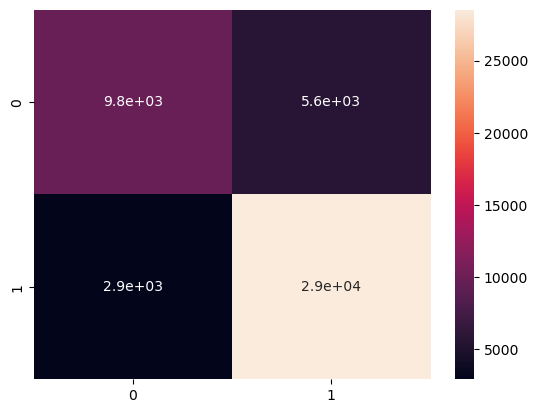

In [84]:
cm = confusion_matrix(y_tst, y_pred)
sns.heatmap(cm, annot=True)

* Logistic Regression also works well.

In [85]:
'''param_grid = {'C':[0.0001, 0.001, 0.01, 0.5, 1, 10, 15, 20, 30, 50, 100],
              'penalty': ['l2', 'l1', 'elasticnet'],
              'solver':['lbfgs', 'liblinear', 'newton-cg', 'saga'],
              'max_iter':[1000],
              'dual': [True],
              'tol':[0.0001, 0.001]
             }'''
#logreg params above
#class_weight not taken as dataset not skewed
#some solvers not taken as they either work worse than similar solvers or they take too long to work (like newton-cholesky).
#took small values of alpha with every type of learning rate available
#used all type of regularisation (ridge, lasso, elasticnet)
#dual just taken as True as n_features>n_samples

"param_grid = {'C':[0.0001, 0.001, 0.01, 0.5, 1, 10, 15, 20, 30, 50, 100],\n              'penalty': ['l2', 'l1', 'elasticnet'],\n              'solver':['lbfgs', 'liblinear', 'newton-cg', 'saga'],\n              'max_iter':[1000],\n              'dual': [True],\n              'tol':[0.0001, 0.001]\n             }"

In [86]:
logreg = LogisticRegression(C=1, dual=True, max_iter=1000, solver='liblinear')
#0.832 f1 score
'''gscv = GridSearchCV(logreg, param_grid=param_grid, cv=5)
gscv.fit(X_trainf, y_trainf)
gscv.best_estimator_'''

'gscv = GridSearchCV(logreg, param_grid=param_grid, cv=5)\ngscv.fit(X_trainf, y_trainf)\ngscv.best_estimator_'

In [87]:
logreg.fit(X_trn, y_trn)
y_pred = logreg.predict(X_tst)
print(classification_report(y_tst, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.62      0.69     15444
           1       0.83      0.91      0.87     31450

    accuracy                           0.82     46894
   macro avg       0.81      0.77      0.78     46894
weighted avg       0.81      0.82      0.81     46894



In [88]:
#Cross-validating the score.
cross_val_score(logreg, X_trainf, y_trainf, cv=5)

array([0.81981896, 0.82250016, 0.82547502, 0.81939735, 0.81984518])

<Axes: >

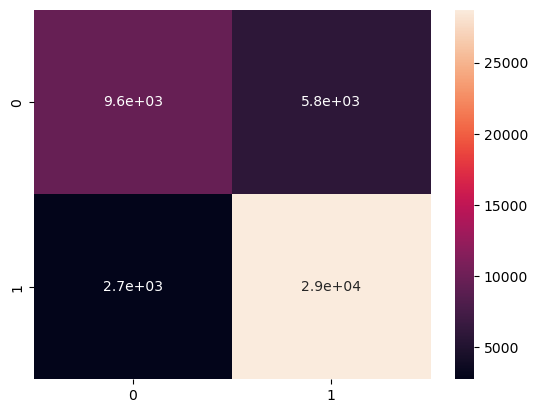

In [89]:
cm = confusion_matrix(y_tst, y_pred)
sns.heatmap(cm, annot=True)

* Linear SVC worked well on a large set of features.
* Kernel approximation (dimensionality reduction) did not help linear SVC as we had hoped.

In [90]:
param_grid = {
    'loss': ['squared_hinge'],
    'penalty': ['l2', 'l1'],
    'C': [0.0001, 0.001, 0.01, 0.5, 1, 10],
    'dual': [True],
    'max_iter': [1000],
    'tol':[0.0001, 0.001]
}
#lsvc params above
#class_weight not taken as dataset not skewed
#dual just taken as True as n_features>n_samples

In [91]:
lsvc= LinearSVC(C=0.5, dual=True)
#0.844 f1 score
'''gscv = GridSearchCV(lsvc, param_grid=param_grid, cv=5)
gscv.fit(X_trainf,y_trainf)
gscv.best_estimator_'''

'gscv = GridSearchCV(lsvc, param_grid=param_grid, cv=5)\ngscv.fit(X_trainf,y_trainf)\ngscv.best_estimator_'

In [92]:
lsvc.fit(X_trn, y_trn)
y_pred = lsvc.predict(X_tst)
print(classification_report(y_tst, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.66      0.73     15444
           1       0.85      0.92      0.88     31450

    accuracy                           0.84     46894
   macro avg       0.83      0.79      0.80     46894
weighted avg       0.83      0.84      0.83     46894



In [93]:
#Cross-validating the score.
cross_val_score(lsvc, X_trainf, y_trainf, cv=5)

array([0.83936283, 0.84153285, 0.84262043, 0.83727849, 0.83843004])

<Axes: >

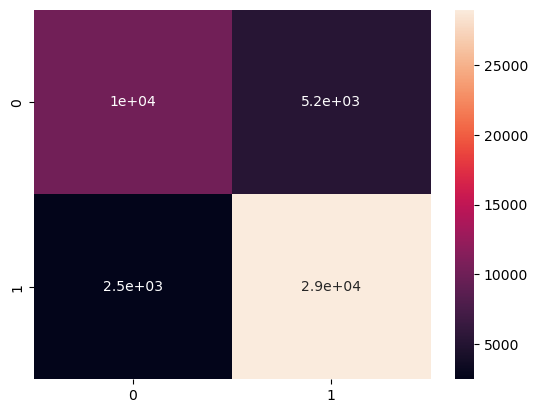

In [94]:
cm = confusion_matrix(y_tst, y_pred)
sns.heatmap(cm, annot=True)

* While all models classify the movies with positive sentiment well, they are not able to identify the movies with negative sentiment well enough.

* Now we make ROC AUC curves for each model to compare the performances.
* We only made ROC curves because as a rule of thumb we should prefer the Precision Recall curve when the positive class is rare, and the ROC curve otherwise.

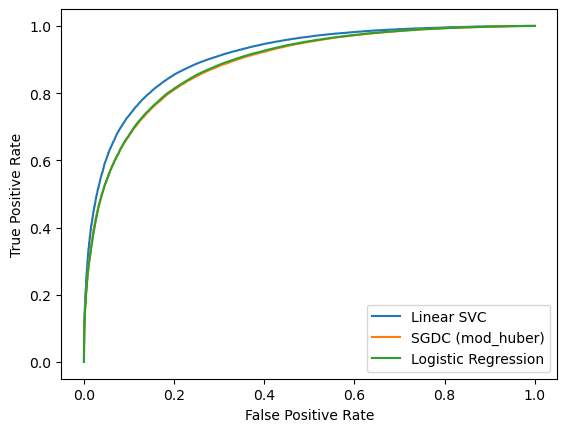

In [95]:
cvp_lsvc = cross_val_predict(lsvc, X_trainf, y_trainf, cv=5, method='decision_function')
cvp_sgd_mod = cross_val_predict(sgd_mod, X_trainf, y_trainf, cv=5, method='decision_function')
cvp_logreg = cross_val_predict(logreg, X_trainf, y_trainf, cv=5, method='decision_function')
fpr, tpr, thresholds = roc_curve(y_trainf, cvp_lsvc)
plt.plot(fpr, tpr, label="Linear SVC")
fpr, tpr, thresholds = roc_curve(y_trainf, cvp_sgd_mod)
plt.plot(fpr, tpr, label="SGDC (mod_huber)")
fpr, tpr, thresholds = roc_curve(y_trainf, cvp_logreg)
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [96]:
print("Area under the curve for Linear SVC:", roc_auc_score(y_trainf, cvp_lsvc))
print("Area under the curve for SGDClassifier:", roc_auc_score(y_trainf, cvp_sgd_mod))
print("Area under the curve for Logistic Regression:", roc_auc_score(y_trainf, cvp_logreg))

Area under the curve for Linear SVC: 0.9087942938316884
Area under the curve for SGDClassifier: 0.8869568381756936
Area under the curve for Logistic Regression: 0.8882564140436406


Following are the main models and their scores for easier comparison-
1. **MLPClassifier:** 0.846
2. **Linear SVC:** 0.844
3. **SGDClassifier:** 0.833
4. **Logistic Regression:** 0.832

* Following is the code to get information from the particular GridSearch Cross Validation done.

In [97]:
#print(gscv.cv_results_)
#print(gscv.best_estimator_)
#print(gscv.best_params_)
#print(gscv.best_score_)

In [98]:
#lsvc.fit(X_trainf,y_trainf)

* Code for making final submission file.

In [99]:
y_pred = mlp.predict(X_testf)
pred_df = pd.DataFrame(le.inverse_transform(y_pred))
pred_df.columns = ["sentiment"]
pred_df.index.name = "id"
pred_df.to_csv("submission.csv")